<p style="padding: 10px;
          color:black;
          text-align: center;
          font-size:250%;">
PySpark Tutorial
</p>

# What is Spark?
- Spark is one of the latest technologies being used to quickly and easily handle Big Data
- It is an open source project on **Apache**
- It was first released in February 2013 and has exploded in popularity due to it’s ease of use and speed
- It was created at the AMPLab at UC Berkeley
- Spark is 100 times faster than **Hadoop MapReduce**
- Spark does not store anything unless any action is applied on the data

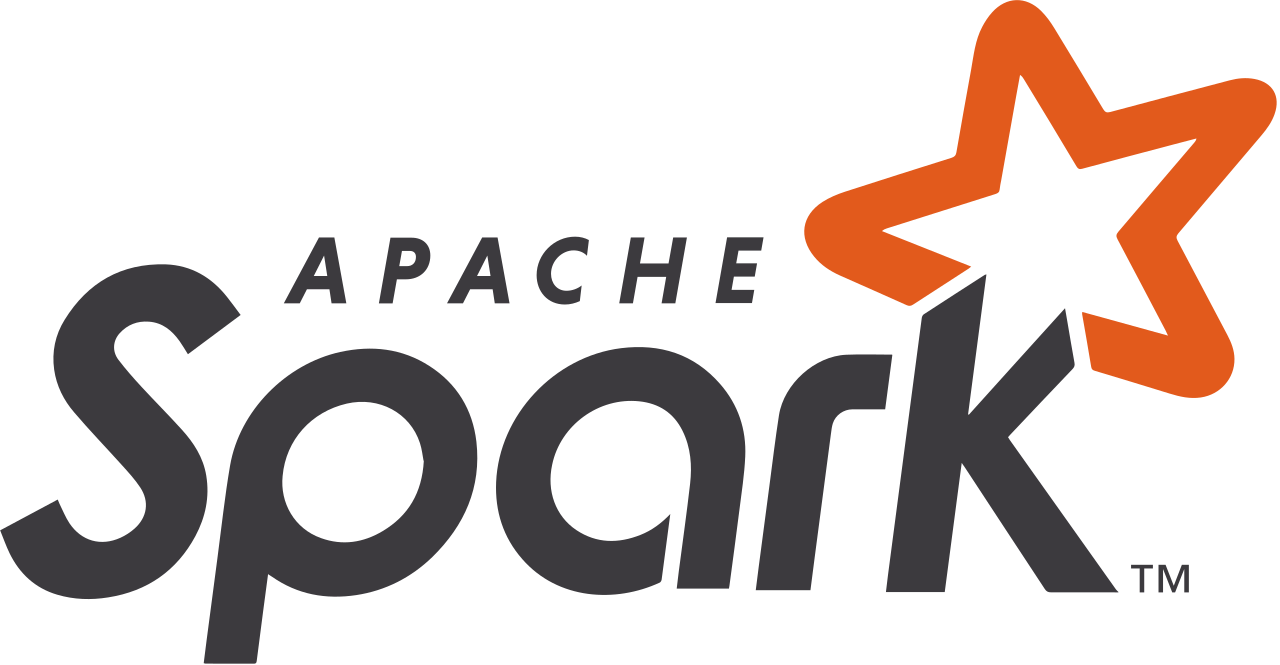

# Libraries and Utilities

We need to install pyspark first

In [67]:
!pip install pyspark

In [68]:
import os
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType
from pyspark.sql.functions import split, count, when, isnan, col, regexp_replace
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/autompg-dataset/auto-mpg.csv


# Creating a SparkSession

In [69]:
spark = SparkSession.builder.appName('First Session').getOrCreate()

print('Spark Version: {}'.format(spark.version))

Spark Version: 3.2.0


# Loading Data

In [70]:
#Defining a Schema
schema = StructType([StructField('mpg', FloatType(), nullable = True),
                     StructField('cylinders', IntegerType(), nullable = True),
                     StructField('displacement', FloatType(), nullable = True),
                     StructField('horsepower', StringType(), nullable = True),
                     StructField('weight', IntegerType(), nullable = True),
                     StructField('acceleration', FloatType(), nullable = True),
                     StructField('model year', IntegerType(), nullable = True),
                     StructField('origin', IntegerType(), nullable = True),
                     StructField('car name', StringType(), nullable = True)])

file_path = '/kaggle/input/autompg-dataset/auto-mpg.csv'

df = spark.read.csv(file_path,
                    header = True,
                    inferSchema = True,
                    nanValue = '?')

df.show(5)

+----+---------+------------+----------+------+------------+----------+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model year|origin|            car name|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
|18.0|        8|       307.0|     130.0|  3504|        12.0|        70|     1|chevrolet chevell...|
|15.0|        8|       350.0|     165.0|  3693|        11.5|        70|     1|   buick skylark 320|
|18.0|        8|       318.0|     150.0|  3436|        11.0|        70|     1|  plymouth satellite|
|16.0|        8|       304.0|     150.0|  3433|        12.0|        70|     1|       amc rebel sst|
|17.0|        8|       302.0|     140.0|  3449|        10.5|        70|     1|         ford torino|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
only showing top 5 rows



In [71]:
#Check Missing Values
def check_missing(dataframe):
    
    return dataframe.select([count(when(isnan(c) | col(c).isNull(), c)). \
                             alias(c) for c in dataframe.columns]).show()

check_missing(df)

+---+---------+------------+----------+------+------------+----------+------+--------+
|mpg|cylinders|displacement|horsepower|weight|acceleration|model year|origin|car name|
+---+---------+------------+----------+------+------------+----------+------+--------+
|  0|        0|           0|         6|     0|           0|         0|     0|       0|
+---+---------+------------+----------+------+------------+----------+------+--------+



In [72]:
#Handling Missing Values
df = df.na.drop()

df = df.withColumn("horsepower", df["horsepower"].cast(IntegerType())) #convert horsepower from string to int

df.show(5)

+----+---------+------------+----------+------+------------+----------+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model year|origin|            car name|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
|18.0|        8|       307.0|       130|  3504|        12.0|        70|     1|chevrolet chevell...|
|15.0|        8|       350.0|       165|  3693|        11.5|        70|     1|   buick skylark 320|
|18.0|        8|       318.0|       150|  3436|        11.0|        70|     1|  plymouth satellite|
|16.0|        8|       304.0|       150|  3433|        12.0|        70|     1|       amc rebel sst|
|17.0|        8|       302.0|       140|  3449|        10.5|        70|     1|         ford torino|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
only showing top 5 rows



# PySpark DataFrame Basics

- Spark DataFrames hold data in a column and row format.
- Each column represents some feature or variable.
- Each row represents an individual data point.
- They are able to input and output data from a wide variety of sources.
- We can then use these DataFrames to apply various transformations on the data.
- At the end of the transformation calls, we can either show or collect the results to display or for some final processing.

In [73]:
#Check column names
df.columns

['mpg',
 'cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'model year',
 'origin',
 'car name']

In [74]:
#Display data with pandas format
df.toPandas().head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [75]:
#Check the schema
df.printSchema()

root
 |-- mpg: double (nullable = true)
 |-- cylinders: integer (nullable = true)
 |-- displacement: double (nullable = true)
 |-- horsepower: integer (nullable = true)
 |-- weight: integer (nullable = true)
 |-- acceleration: double (nullable = true)
 |-- model year: integer (nullable = true)
 |-- origin: integer (nullable = true)
 |-- car name: string (nullable = true)



In [76]:
#Renaming Columns
df = df.withColumnRenamed('model year', 'model_year')

df = df.withColumnRenamed('car name', 'car_name')

df.show(3)

+----+---------+------------+----------+------+------------+----------+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model_year|origin|            car_name|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
|18.0|        8|       307.0|       130|  3504|        12.0|        70|     1|chevrolet chevell...|
|15.0|        8|       350.0|       165|  3693|        11.5|        70|     1|   buick skylark 320|
|18.0|        8|       318.0|       150|  3436|        11.0|        70|     1|  plymouth satellite|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
only showing top 3 rows



In [77]:
#Get infos from first 4 rows
for car in df.head(4):
    print(car, '\n')

Row(mpg=18.0, cylinders=8, displacement=307.0, horsepower=130, weight=3504, acceleration=12.0, model_year=70, origin=1, car_name='chevrolet chevelle malibu') 

Row(mpg=15.0, cylinders=8, displacement=350.0, horsepower=165, weight=3693, acceleration=11.5, model_year=70, origin=1, car_name='buick skylark 320') 

Row(mpg=18.0, cylinders=8, displacement=318.0, horsepower=150, weight=3436, acceleration=11.0, model_year=70, origin=1, car_name='plymouth satellite') 

Row(mpg=16.0, cylinders=8, displacement=304.0, horsepower=150, weight=3433, acceleration=12.0, model_year=70, origin=1, car_name='amc rebel sst') 



In [78]:
#statistical summary of dataframe
df.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+
|summary|              mpg|         cylinders|      displacement|        horsepower|            weight|      acceleration|       model_year|            origin|            car_name|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+
|  count|              392|               392|               392|               392|               392|               392|              392|               392|                 392|
|   mean|23.44591836734694| 5.471938775510204|194.41198979591837|104.46938775510205|2977.5841836734694|15.541326530612228| 75.9795918367347|1.5765306122448979|                null|
| stddev|7.805007486571802|1.7057832474527845|104.64400390890465| 38.49115993282846| 849.402560

- <code>describe()</code> represents the statiscal summary of dataframe but it also uses the string variables

In [79]:
#describe with specific variables
df.describe(['mpg', 'horsepower']).show()

+-------+-----------------+------------------+
|summary|              mpg|        horsepower|
+-------+-----------------+------------------+
|  count|              392|               392|
|   mean|23.44591836734694|104.46938775510205|
| stddev|7.805007486571802| 38.49115993282846|
|    min|              9.0|                46|
|    max|             46.6|               230|
+-------+-----------------+------------------+



In [80]:
#describe with numerical columns
def get_num_cols(dataframe):
    
    num_cols = [col for col in dataframe.columns if dataframe.select(col). \
                dtypes[0][1] in ['double', 'int']]
    
    return num_cols

num_cols = get_num_cols(df)
    
df.describe(num_cols).show()

+-------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|              mpg|         cylinders|      displacement|        horsepower|            weight|      acceleration|       model_year|            origin|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|              392|               392|               392|               392|               392|               392|              392|               392|
|   mean|23.44591836734694| 5.471938775510204|194.41198979591837|104.46938775510205|2977.5841836734694|15.541326530612228| 75.9795918367347|1.5765306122448979|
| stddev|7.805007486571802|1.7057832474527845|104.64400390890465| 38.49115993282846| 849.4025600429486|  2.75886411918808|3.683736543577868|0.8055181834183057|
|    min|              9.0|             

# Spark DataFrame Basic Operations

## Filtering & Sorting

In [81]:
#Lets get the cars with mpg more than 23
df.filter(df['mpg'] > 23).show(5)

+----+---------+------------+----------+------+------------+----------+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model_year|origin|            car_name|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
|24.0|        4|       113.0|        95|  2372|        15.0|        70|     3|toyota corona mar...|
|27.0|        4|        97.0|        88|  2130|        14.5|        70|     3|        datsun pl510|
|26.0|        4|        97.0|        46|  1835|        20.5|        70|     2|volkswagen 1131 d...|
|25.0|        4|       110.0|        87|  2672|        17.5|        70|     2|         peugeot 504|
|24.0|        4|       107.0|        90|  2430|        14.5|        70|     2|         audi 100 ls|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
only showing top 5 rows



In [82]:
#Multiple Conditions
df.filter((df['horsepower'] > 80) & 
          (df['weight'] > 2000)).select('car_name').show(5)

+--------------------+
|            car_name|
+--------------------+
|chevrolet chevell...|
|   buick skylark 320|
|  plymouth satellite|
|       amc rebel sst|
|         ford torino|
+--------------------+
only showing top 5 rows



In [83]:
#Sorting
df.filter((df['mpg'] > 25) & (df['origin'] == 2)). \
orderBy('mpg', ascending = False).show(5)

+----+---------+------------+----------+------+------------+----------+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model_year|origin|            car_name|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
|44.3|        4|        90.0|        48|  2085|        21.7|        80|     2|vw rabbit c (diesel)|
|44.0|        4|        97.0|        52|  2130|        24.6|        82|     2|           vw pickup|
|43.4|        4|        90.0|        48|  2335|        23.7|        80|     2|  vw dasher (diesel)|
|43.1|        4|        90.0|        48|  1985|        21.5|        78|     2|volkswagen rabbit...|
|41.5|        4|        98.0|        76|  2144|        14.7|        80|     2|           vw rabbit|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
only showing top 5 rows



In [84]:
#Get the cars with 'volkswagen' in their names, and sort them by model year and horsepower
df.filter(df['car_name'].contains('volkswagen')). \
orderBy(['model_year', 'horsepower'], ascending=[False, False]).show(5)

+----+---------+------------+----------+------+------------+----------+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model_year|origin|            car_name|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
|36.0|        4|       105.0|        74|  1980|        15.3|        82|     2| volkswagen rabbit l|
|33.0|        4|       105.0|        74|  2190|        14.2|        81|     2|    volkswagen jetta|
|31.5|        4|        89.0|        71|  1990|        14.9|        78|     2| volkswagen scirocco|
|43.1|        4|        90.0|        48|  1985|        21.5|        78|     2|volkswagen rabbit...|
|29.0|        4|        97.0|        78|  1940|        14.5|        77|     2|volkswagen rabbit...|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
only showing top 5 rows



In [85]:
df.filter(df['car_name'].like('%volkswagen%')).show(3)

+----+---------+------------+----------+------+------------+----------+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model_year|origin|            car_name|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
|26.0|        4|        97.0|        46|  1835|        20.5|        70|     2|volkswagen 1131 d...|
|27.0|        4|        97.0|        60|  1834|        19.0|        71|     2|volkswagen model 111|
|23.0|        4|        97.0|        54|  2254|        23.5|        72|     2|   volkswagen type 3|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
only showing top 3 rows



## Filtering with SQL

In [86]:
#Get the cars with 'toyota' in their names
df.filter("car_name like '%toyota%'").show(5)

+----+---------+------------+----------+------+------------+----------+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model_year|origin|            car_name|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
|24.0|        4|       113.0|        95|  2372|        15.0|        70|     3|toyota corona mar...|
|25.0|        4|       113.0|        95|  2228|        14.0|        71|     3|       toyota corona|
|31.0|        4|        71.0|        65|  1773|        19.0|        71|     3| toyota corolla 1200|
|24.0|        4|       113.0|        95|  2278|        15.5|        72|     3|toyota corona har...|
|27.0|        4|        97.0|        88|  2100|        16.5|        72|     3|toyota corolla 16...|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
only showing top 5 rows



In [87]:
df.filter('mpg > 22').show(5)

+----+---------+------------+----------+------+------------+----------+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model_year|origin|            car_name|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
|24.0|        4|       113.0|        95|  2372|        15.0|        70|     3|toyota corona mar...|
|27.0|        4|        97.0|        88|  2130|        14.5|        70|     3|        datsun pl510|
|26.0|        4|        97.0|        46|  1835|        20.5|        70|     2|volkswagen 1131 d...|
|25.0|        4|       110.0|        87|  2672|        17.5|        70|     2|         peugeot 504|
|24.0|        4|       107.0|        90|  2430|        14.5|        70|     2|         audi 100 ls|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
only showing top 5 rows



In [88]:
#Multiple Conditions
df.filter('mpg > 22 and acceleration < 15').show(5)

+----+---------+------------+----------+------+------------+----------+------+-------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model_year|origin|     car_name|
+----+---------+------------+----------+------+------------+----------+------+-------------+
|27.0|        4|        97.0|        88|  2130|        14.5|        70|     3| datsun pl510|
|24.0|        4|       107.0|        90|  2430|        14.5|        70|     2|  audi 100 ls|
|26.0|        4|       121.0|       113|  2234|        12.5|        70|     2|     bmw 2002|
|27.0|        4|        97.0|        88|  2130|        14.5|        71|     3| datsun pl510|
|25.0|        4|       113.0|        95|  2228|        14.0|        71|     3|toyota corona|
+----+---------+------------+----------+------+------------+----------+------+-------------+
only showing top 5 rows



In [89]:
df.filter('horsepower == 88 and weight between 2600 and 3000') \
.select(['horsepower', 'weight', 'car_name']).show()

+----------+------+--------------------+
|horsepower|weight|            car_name|
+----------+------+--------------------+
|        88|  2957|         peugeot 504|
|        88|  2740|pontiac sunbird c...|
|        88|  2720| ford fairmont (man)|
|        88|  2890|     ford fairmont 4|
|        88|  2870|       ford fairmont|
|        88|  2605|  chevrolet cavalier|
|        88|  2640|chevrolet cavalie...|
+----------+------+--------------------+



# GroupBy and Aggregate Operations

In [90]:
#Brands
df.createOrReplaceTempView('auto_mpg')

df = df.withColumn('brand', split(df['car_name'], ' ').getItem(0)).drop('car_name')

#Replacing Misspelled Brands
auto_misspelled = {'chevroelt': 'chevrolet',
                   'chevy': 'chevrolet',
                   'vokswagen': 'volkswagen',
                   'vw': 'volkswagen',
                   'hi': 'harvester',
                   'maxda': 'mazda',
                   'toyouta': 'toyota',
                   'mercedes-benz': 'mercedes'}

for key in auto_misspelled.keys():
    
    df = df.withColumn('brand', regexp_replace('brand', key, auto_misspelled[key]))

df.show(5)

+----+---------+------------+----------+------+------------+----------+------+---------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model_year|origin|    brand|
+----+---------+------------+----------+------+------------+----------+------+---------+
|18.0|        8|       307.0|       130|  3504|        12.0|        70|     1|chevrolet|
|15.0|        8|       350.0|       165|  3693|        11.5|        70|     1|    buick|
|18.0|        8|       318.0|       150|  3436|        11.0|        70|     1| plymouth|
|16.0|        8|       304.0|       150|  3433|        12.0|        70|     1|      amc|
|17.0|        8|       302.0|       140|  3449|        10.5|        70|     1|     ford|
+----+---------+------------+----------+------+------------+----------+------+---------+
only showing top 5 rows



In [91]:
#Avg Acceleration by car brands
df.groupBy('brand').agg({'acceleration': 'mean'}).show(5)

+--------+------------------+
|   brand| avg(acceleration)|
+--------+------------------+
|   buick|14.700000000000003|
| pontiac|14.081249999999999|
|mercedes| 19.53333333333333|
|  toyota| 16.03846153846154|
|    saab|            15.175|
+--------+------------------+
only showing top 5 rows



In [92]:
#Max MPG by car brands
df.groupBy('brand').agg({'mpg': 'max'}).show(5)

+--------+--------+
|   brand|max(mpg)|
+--------+--------+
|   buick|    30.0|
| pontiac|    33.5|
|mercedes|    30.0|
|  toyota|    39.1|
|    saab|    25.0|
+--------+--------+
only showing top 5 rows



# Machine Learning

- Machine learning is a method of data analysis that automates analytical model building. 
- Using algorithms that iteratively learn from data, machine learning allows computers to find hidden insights without being explicitly programmed where to look.

## Supervised Learning

- Spark’s MLlib is mainly designed for **Supervised** and **Unsupervised Learning** tasks, with most of its algorithms falling under those two categories.
- Supervised learning algorithms are trained using labeled examples, such as an input where the desired output is known. 
- For example, a piece of equipment could have data points labeled either “F” (failed) or “R” (runs). 
- The learning algorithm receives a set of inputs along with the corresponding correct outputs, and the algorithm learns by comparing its actual output with correct outputs to find errors. 
- It then modifies the model accordingly.
- Through methods like classification, regression, prediction and gradient boosting, supervised learning uses patterns to predict the values of the label on additional unlabeled data. 
- Supervised learning is commonly used in applications where historical data predicts likely future events.
- For example, it can anticipate when credit card transactions are likely to be fraudulent or which insurance customer is likely to file a claim.
- Or it can attempt to predict the price of a house based on different features for houses for which we have historical price data.

## Unsupervised Learning

- Unsupervised learning is used against data that has no historical labels. 
- The system is not told the "right answer." The algorithm must figure out what is being shown. 
- The goal is to explore the data and find some structure within.
- For example, it can find the main attributes that separate customer segments from each other. 
- Popular techniques include self-organizing maps, nearest-neighbor mapping, k-means clustering and singular value decomposition.
- One issue is that it can be difficult to evaluate results of an unsupervised model!

# Machine Learning with PySpark

- Spark has its own MLlib for Machine Learning.
- The future of MLlib utilizes the Spark 2.0 DataFrame syntax.
- One of the main “quirks” of using MLlib is that you need to format your data so that eventually  it just has one or two columns:
    - Features, Labels (Supervised)
    - Features (Unsupervised)
- This requires a little more data processing work than some other machine learning libraries, but the big upside is that this exact same syntax works with distributed data, which is no small feat for what is going on “under the hood”!
- When working with Python and Spark with MLlib, the documentation examples are always with nicely formatted data.
- A huge part of learning MLlib is getting comfortable with the documentation!
- Being able to master the skill of finding information (not memorization) is the key to becoming a great Spark and Python developer!
- Let’s jump to it now!

Learn more in here: https://spark.apache.org/mllib/

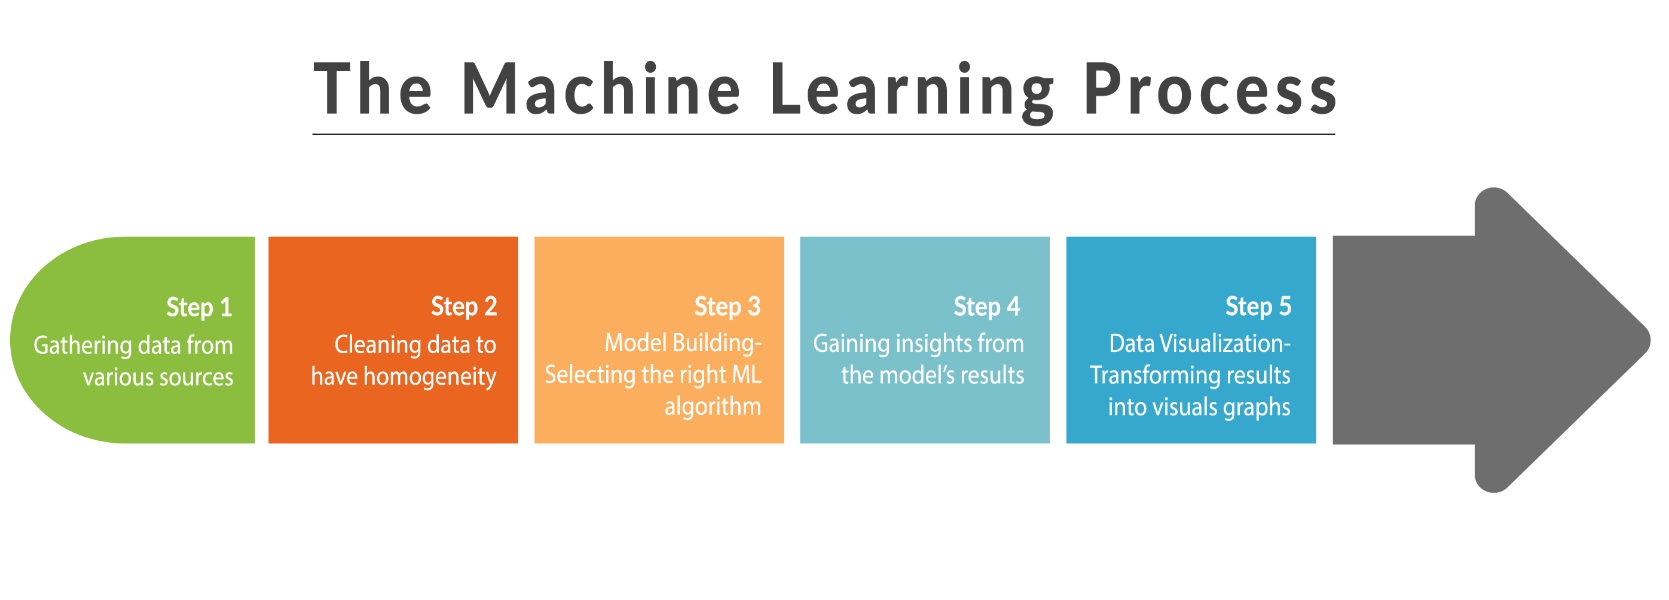

# Preprocessing

## Encoding Brands

In [93]:
#Check brand frequences first
df.groupby('brand').count().orderBy('count', ascending = False).show(5)

+---------+-----+
|    brand|count|
+---------+-----+
|     ford|   48|
|chevrolet|   47|
| plymouth|   31|
|    dodge|   28|
|      amc|   27|
+---------+-----+
only showing top 5 rows



In [94]:
def one_hot_encoder(dataframe, col):
    
    indexed = StringIndexer().setInputCol(col).setOutputCol(col + '_cat'). \
    fit(dataframe).transform(dataframe) #converting categorical values into category indices
    
    ohe = OneHotEncoder().setInputCol(col + '_cat').setOutputCol(col + '_OneHotEncoded'). \
    fit(indexed).transform(indexed)
    
    ohe = ohe.drop(*[col, col + '_cat'])
    
    return ohe

df = one_hot_encoder(df, col = 'brand')
df.show(5)

+----+---------+------------+----------+------+------------+----------+------+-------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model_year|origin|brand_OneHotEncoded|
+----+---------+------------+----------+------+------------+----------+------+-------------------+
|18.0|        8|       307.0|       130|  3504|        12.0|        70|     1|     (29,[1],[1.0])|
|15.0|        8|       350.0|       165|  3693|        11.5|        70|     1|     (29,[8],[1.0])|
|18.0|        8|       318.0|       150|  3436|        11.0|        70|     1|     (29,[2],[1.0])|
|16.0|        8|       304.0|       150|  3433|        12.0|        70|     1|     (29,[4],[1.0])|
|17.0|        8|       302.0|       140|  3449|        10.5|        70|     1|     (29,[0],[1.0])|
+----+---------+------------+----------+------+------------+----------+------+-------------------+
only showing top 5 rows



In [95]:
#Vector Assembler
def vector_assembler(dataframe, indep_cols):
    
    assembler = VectorAssembler(inputCols = indep_cols,
                                outputCol = 'features')

    output = assembler.transform(dataframe).drop(*indep_cols)
    
    return output

df = vector_assembler(df, indep_cols = df.drop('mpg').columns)
df.show(5)

+----+--------------------+
| mpg|            features|
+----+--------------------+
|18.0|(36,[0,1,2,3,4,5,...|
|15.0|(36,[0,1,2,3,4,5,...|
|18.0|(36,[0,1,2,3,4,5,...|
|16.0|(36,[0,1,2,3,4,5,...|
|17.0|(36,[0,1,2,3,4,5,...|
+----+--------------------+
only showing top 5 rows



## Train-Test Split

In [96]:
train_data, test_data = df.randomSplit([0.8, 0.2])

print('Train Shape: ({}, {})'.format(train_data.count(), len(train_data.columns)))
print('Test Shape: ({}, {})'.format(test_data.count(), len(test_data.columns)))

Train Shape: (307, 2)
Test Shape: (85, 2)


# Multiple Linear Regression with PySpark

## Fit the Model

In [97]:
lr = LinearRegression(labelCol = 'mpg',
                      featuresCol = 'features',
                      regParam = 0.3) #avoid overfitting

lr = lr.fit(train_data)

## Model Evaluation

In [98]:
def evaluate_reg_model(model, test_data):
    
    print(model.__class__.__name__.center(70, '-'))
    model_results = model.evaluate(test_data)
    print('R2: {}'.format(model_results.r2))
    print('MSE: {}'.format(model_results.meanSquaredError))
    print('RMSE: {}'.format(model_results.rootMeanSquaredError))
    print('MAE: {}'.format(model_results.meanAbsoluteError))
    print(70*'-')

evaluate_reg_model(lr, test_data)

------------------------LinearRegressionModel-------------------------
R2: 0.8518062895686702
MSE: 8.593806392024922
RMSE: 2.931519468129953
MAE: 2.259797854543087
----------------------------------------------------------------------


In [99]:
#End Session
spark.stop()

**If you liked this notebook, please upvote** 😊

**If you have any suggestions or questions, feel free to comment!**

**Best Wishes!**